In [112]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm

In [113]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, random_split
import json
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, random_split

class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path)
        
        # encode the 'Protocole' column
        if 'Protocol' in df.columns:  # Check if the column exists
            self.le_protocole = LabelEncoder()
            df['Protocol'] = self.le_protocole.fit_transform(df['Protocol'])
        
        # store the inputs and outputs
        self.X = df.drop(columns=df.columns[-1]).values  # Drop the last column for features
        self.y = df.iloc[:, -1].values  # Last column is the target
        
        # ensure input data is floats
        self.X = self.X.astype('float32')
        
        # normalize the input features
        self.scaler = StandardScaler()  # You can use MinMaxScaler() for [0, 1] range
        self.X = self.scaler.fit_transform(self.X)
        
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

    # Method to save only the X values as JSON
    def save_row_as_json(self, idx, filename):
        # Extraire la ligne spécifiée (X)
        row = self[idx]  # Cela appelle __getitem__
        features = row[0]  # Caractéristiques (X)

        # Créer un dictionnaire avec les données
        data = {
            'features': features.tolist()  # Convertir en liste pour JSON
        }

        # Sauvegarder le dictionnaire en JSON
        with open(filename, 'w') as f:
            json.dump(data, f)
    def print_data(self):
        print("Scaled and Normalized Features (X):")
        print(self.X)
        print("Labels (y):")
        print(self.y)

    def get_row_for_prediction(self, idx):
        """
        This method returns the row of X (features) for a given index (idx).
        Useful for making predictions with a trained model.
        """
        return self.X[idx]

   


In [114]:
import torch
from torch.nn import Module, Linear, ReLU, Sigmoid, Dropout
from torch.nn.init import kaiming_uniform_, xavier_uniform_

class MLP(Module):
    def __init__(self, n_inputs, dropout_prob=0.5):
        super(MLP, self).__init__()
        # Couche 1
        self.hidden1 = Linear(n_inputs, 128)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.dropout1 = Dropout(dropout_prob)  # Dropout après la première couche cachée
        
        # Couche 2
        self.hidden2 = Linear(128, 64)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.dropout2 = Dropout(dropout_prob)  # Dropout après la deuxième couche cachée
        
        # Couche 3
        self.hidden3 = Linear(64, 32)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        self.dropout3 = Dropout(dropout_prob)  # Dropout après la troisième couche cachée
        
        # Couche de sortie
        self.output = Linear(32, 1)
        xavier_uniform_(self.output.weight)
        self.act_out = Sigmoid()

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X)  # Appliquer le dropout après la première couche
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.dropout2(X)  # Appliquer le dropout après la deuxième couche
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.dropout3(X)  # Appliquer le dropout après la troisième couche
        X = self.output(X)
        X = self.act_out(X)
        return X


In [115]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=512, shuffle=True)
    test_dl = DataLoader(test, batch_size=512, shuffle=False)
    return train_dl, test_dl

In [116]:
from sklearn.metrics import accuracy_score
import torch
from torch.nn import BCELoss
from torch.optim import SGD
from tqdm import tqdm
from numpy import vstack
import matplotlib.pyplot as plt

# Function to train the model
from sklearn.metrics import accuracy_score
import torch
from torch.nn import BCELoss
from torch.optim import SGD
from tqdm import tqdm
from numpy import vstack
import matplotlib.pyplot as plt

# Function to train the model
def train_model(train_dl, test_dl, model):
    train_accs = []  # Liste pour stocker la précision d'entraînement
    test_accs = []   # Liste pour stocker la précision de test
    train_losses = []  # Liste pour stocker la perte d'entraînement
    test_losses = []   # Liste pour stocker la perte de test

    size = len(train_dl.dataset)
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)

    # Entraînement pendant 100 époques
    for epoch in tqdm(range(100), desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        # Entraînement sur les mini-batchs
        epoch_train_loss = 0  # Variable pour stocker la perte cumulée d'entraînement
        for batch, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()  # Annuler les gradients
            yhat = model(inputs)   # Calculer les prédictions
            loss = criterion(yhat, targets)  # Calculer la perte
            loss.backward()  # Rétropropagation des gradients
            optimizer.step()  # Mise à jour des poids
            
            epoch_train_loss += loss.item()  # Ajouter la perte du batch à la perte d'entraînement

        # Calcul de la perte moyenne pour l'entraînement
        avg_train_loss = epoch_train_loss / len(train_dl)
        train_losses.append(avg_train_loss)  # Ajouter la perte moyenne d'entraînement à la liste

        # Calcul de la précision d'entraînement et de test à la fin de chaque époque
        train_accuracy = evaluate_model(train_dl, model)
        test_accuracy = evaluate_model(test_dl, model)
        
        # Calcul de la perte sur l'ensemble de test
        test_loss = evaluate_loss(test_dl, model, criterion)
        
        # Ajouter les précisions et pertes à la liste
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)
        test_losses.append(test_loss)

        print(f"Train Accuracy: {train_accuracy*100:.2f}%  Test Accuracy: {test_accuracy*100:.2f}%  Train Loss: {avg_train_loss:.4f}  Test Loss: {test_loss:.4f}")
    
    # Tracer les courbes de précision et de perte
    plot_accuracy(train_accs, test_accs)
    plot_loss(train_losses, test_losses)


In [117]:
def evaluate_model(data_dl, model):
    predictions, actuals = list(), list()
    for inputs, targets in data_dl:
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.round()
        predictions.append(yhat)
        actuals.append(actual)
    
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

# Function to evaluate the loss of the model
def evaluate_loss(data_dl, model, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, targets in data_dl:
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            total_loss += loss.item()
    
    # Calculer la perte moyenne sur l'ensemble de test
    avg_loss = total_loss / len(data_dl)
    model.train()  # Revenir en mode entraînement
    return avg_loss

In [118]:
def plot_accuracy(train_accs, test_accs):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label="Train Accuracy", color='blue', linestyle='-', marker='o')
    plt.plot(test_accs, label="Test Accuracy", color='red', linestyle='-', marker='o')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot the loss
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", color='green', linestyle='-', marker='o')
    plt.plot(test_losses, label="Test Loss", color='orange', linestyle='-', marker='o')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

305432 150437


Training Epochs:   0%|                                  | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------


Training Epochs:   1%|▎                         | 1/100 [00:11<19:11, 11.63s/it]

Train Accuracy: 98.75%  Test Accuracy: 98.75%  Train Loss: 0.1796  Test Loss: 0.0346
Epoch 2
-------------------------------


Training Epochs:   2%|▌                         | 2/100 [00:21<16:55, 10.36s/it]

Train Accuracy: 99.24%  Test Accuracy: 99.23%  Train Loss: 0.0744  Test Loss: 0.0272
Epoch 3
-------------------------------


Training Epochs:   3%|▊                         | 3/100 [00:29<15:30,  9.59s/it]

Train Accuracy: 99.34%  Test Accuracy: 99.37%  Train Loss: 0.0572  Test Loss: 0.0232
Epoch 4
-------------------------------


Training Epochs:   4%|█                         | 4/100 [00:39<15:20,  9.59s/it]

Train Accuracy: 99.42%  Test Accuracy: 99.44%  Train Loss: 0.0465  Test Loss: 0.0215
Epoch 5
-------------------------------


Training Epochs:   5%|█▎                        | 5/100 [00:49<15:32,  9.82s/it]

Train Accuracy: 99.45%  Test Accuracy: 99.48%  Train Loss: 0.0393  Test Loss: 0.0210
Epoch 6
-------------------------------


Training Epochs:   6%|█▌                        | 6/100 [00:58<14:58,  9.55s/it]

Train Accuracy: 99.47%  Test Accuracy: 99.53%  Train Loss: 0.0376  Test Loss: 0.0199
Epoch 7
-------------------------------


Training Epochs:   7%|█▊                        | 7/100 [01:08<14:48,  9.56s/it]

Train Accuracy: 99.49%  Test Accuracy: 99.51%  Train Loss: 0.0322  Test Loss: 0.0190
Epoch 8
-------------------------------


Training Epochs:   8%|██                        | 8/100 [01:19<15:22, 10.03s/it]

Train Accuracy: 99.51%  Test Accuracy: 99.54%  Train Loss: 0.0303  Test Loss: 0.0187
Epoch 9
-------------------------------


Training Epochs:   9%|██▎                       | 9/100 [01:29<15:07,  9.98s/it]

Train Accuracy: 99.52%  Test Accuracy: 99.56%  Train Loss: 0.0293  Test Loss: 0.0179
Epoch 10
-------------------------------


Training Epochs:  10%|██▌                      | 10/100 [01:38<14:53,  9.93s/it]

Train Accuracy: 99.54%  Test Accuracy: 99.55%  Train Loss: 0.0293  Test Loss: 0.0182
Epoch 11
-------------------------------


Training Epochs:  11%|██▊                      | 11/100 [01:48<14:34,  9.83s/it]

Train Accuracy: 99.54%  Test Accuracy: 99.58%  Train Loss: 0.0275  Test Loss: 0.0175
Epoch 12
-------------------------------


Training Epochs:  12%|███                      | 12/100 [01:58<14:21,  9.79s/it]

Train Accuracy: 99.54%  Test Accuracy: 99.57%  Train Loss: 0.0269  Test Loss: 0.0174
Epoch 13
-------------------------------


Training Epochs:  13%|███▎                     | 13/100 [02:07<13:51,  9.55s/it]

Train Accuracy: 99.54%  Test Accuracy: 99.58%  Train Loss: 0.0249  Test Loss: 0.0162
Epoch 14
-------------------------------


Training Epochs:  14%|███▌                     | 14/100 [02:17<13:56,  9.72s/it]

Train Accuracy: 99.55%  Test Accuracy: 99.61%  Train Loss: 0.0238  Test Loss: 0.0160
Epoch 15
-------------------------------


Training Epochs:  15%|███▊                     | 15/100 [02:27<14:04,  9.94s/it]

Train Accuracy: 99.57%  Test Accuracy: 99.59%  Train Loss: 0.0227  Test Loss: 0.0158
Epoch 16
-------------------------------


Training Epochs:  16%|████                     | 16/100 [02:37<13:57,  9.97s/it]

Train Accuracy: 99.58%  Test Accuracy: 99.59%  Train Loss: 0.0225  Test Loss: 0.0157
Epoch 17
-------------------------------


Training Epochs:  17%|████▎                    | 17/100 [02:48<14:08, 10.22s/it]

Train Accuracy: 99.58%  Test Accuracy: 99.62%  Train Loss: 0.0225  Test Loss: 0.0156
Epoch 18
-------------------------------


Training Epochs:  18%|████▌                    | 18/100 [02:58<13:42, 10.03s/it]

Train Accuracy: 99.58%  Test Accuracy: 99.63%  Train Loss: 0.0202  Test Loss: 0.0155
Epoch 19
-------------------------------


Training Epochs:  19%|████▊                    | 19/100 [03:07<13:13,  9.79s/it]

Train Accuracy: 99.59%  Test Accuracy: 99.63%  Train Loss: 0.0215  Test Loss: 0.0154
Epoch 20
-------------------------------


Training Epochs:  20%|█████                    | 20/100 [03:20<14:17, 10.72s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.63%  Train Loss: 0.0206  Test Loss: 0.0147
Epoch 21
-------------------------------


Training Epochs:  21%|█████▎                   | 21/100 [03:33<15:05, 11.46s/it]

Train Accuracy: 99.60%  Test Accuracy: 99.64%  Train Loss: 0.0202  Test Loss: 0.0146
Epoch 22
-------------------------------


Training Epochs:  22%|█████▌                   | 22/100 [03:44<14:34, 11.22s/it]

Train Accuracy: 99.60%  Test Accuracy: 99.64%  Train Loss: 0.0207  Test Loss: 0.0144
Epoch 23
-------------------------------


Training Epochs:  23%|█████▊                   | 23/100 [03:55<14:20, 11.18s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.65%  Train Loss: 0.0205  Test Loss: 0.0144
Epoch 24
-------------------------------


Training Epochs:  24%|██████                   | 24/100 [04:07<14:35, 11.53s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.65%  Train Loss: 0.0206  Test Loss: 0.0143
Epoch 25
-------------------------------


Training Epochs:  25%|██████▎                  | 25/100 [04:18<14:01, 11.21s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.64%  Train Loss: 0.0195  Test Loss: 0.0142
Epoch 26
-------------------------------


Training Epochs:  26%|██████▌                  | 26/100 [04:28<13:41, 11.09s/it]

Train Accuracy: 99.60%  Test Accuracy: 99.63%  Train Loss: 0.0173  Test Loss: 0.0141
Epoch 27
-------------------------------


Training Epochs:  27%|██████▊                  | 27/100 [04:38<13:07, 10.79s/it]

Train Accuracy: 99.62%  Test Accuracy: 99.65%  Train Loss: 0.0185  Test Loss: 0.0140
Epoch 28
-------------------------------


Training Epochs:  28%|███████                  | 28/100 [04:48<12:33, 10.47s/it]

Train Accuracy: 99.62%  Test Accuracy: 99.65%  Train Loss: 0.0182  Test Loss: 0.0133
Epoch 29
-------------------------------


Training Epochs:  29%|███████▏                 | 29/100 [04:59<12:32, 10.59s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.66%  Train Loss: 0.0182  Test Loss: 0.0126
Epoch 30
-------------------------------


Training Epochs:  30%|███████▌                 | 30/100 [05:09<12:15, 10.50s/it]

Train Accuracy: 99.61%  Test Accuracy: 99.66%  Train Loss: 0.0163  Test Loss: 0.0103
Epoch 31
-------------------------------


Training Epochs:  31%|███████▊                 | 31/100 [05:19<11:49, 10.28s/it]

Train Accuracy: 99.63%  Test Accuracy: 99.64%  Train Loss: 0.0165  Test Loss: 0.0101
Epoch 32
-------------------------------


Training Epochs:  32%|████████                 | 32/100 [05:31<12:02, 10.62s/it]

Train Accuracy: 99.63%  Test Accuracy: 99.66%  Train Loss: 0.0155  Test Loss: 0.0093
Epoch 33
-------------------------------


Training Epochs:  33%|████████▎                | 33/100 [05:44<12:38, 11.32s/it]

Train Accuracy: 99.62%  Test Accuracy: 99.68%  Train Loss: 0.0140  Test Loss: 0.0092
Epoch 34
-------------------------------


Training Epochs:  34%|████████▌                | 34/100 [05:54<12:02, 10.94s/it]

Train Accuracy: 99.63%  Test Accuracy: 99.64%  Train Loss: 0.0149  Test Loss: 0.0092
Epoch 35
-------------------------------


Training Epochs:  35%|████████▊                | 35/100 [06:03<11:18, 10.44s/it]

Train Accuracy: 99.63%  Test Accuracy: 99.65%  Train Loss: 0.0129  Test Loss: 0.0091
Epoch 36
-------------------------------


Training Epochs:  36%|█████████                | 36/100 [06:12<10:40, 10.00s/it]

Train Accuracy: 99.64%  Test Accuracy: 99.68%  Train Loss: 0.0141  Test Loss: 0.0092
Epoch 37
-------------------------------


Training Epochs:  37%|█████████▎               | 37/100 [06:21<10:07,  9.64s/it]

Train Accuracy: 99.63%  Test Accuracy: 99.68%  Train Loss: 0.0136  Test Loss: 0.0091
Epoch 38
-------------------------------


Training Epochs:  38%|█████████▌               | 38/100 [06:30<09:49,  9.51s/it]

Train Accuracy: 99.64%  Test Accuracy: 99.66%  Train Loss: 0.0138  Test Loss: 0.0089
Epoch 39
-------------------------------


Training Epochs:  39%|█████████▊               | 39/100 [06:42<10:23, 10.22s/it]

Train Accuracy: 99.65%  Test Accuracy: 99.68%  Train Loss: 0.0110  Test Loss: 0.0088
Epoch 40
-------------------------------


Training Epochs:  40%|██████████               | 40/100 [06:53<10:24, 10.40s/it]

Train Accuracy: 99.65%  Test Accuracy: 99.67%  Train Loss: 0.0135  Test Loss: 0.0088
Epoch 41
-------------------------------


Training Epochs:  41%|██████████▎              | 41/100 [07:03<10:23, 10.56s/it]

Train Accuracy: 99.64%  Test Accuracy: 99.68%  Train Loss: 0.0119  Test Loss: 0.0087
Epoch 42
-------------------------------


Training Epochs:  42%|██████████▌              | 42/100 [07:13<09:56, 10.29s/it]

Train Accuracy: 99.64%  Test Accuracy: 99.67%  Train Loss: 0.0130  Test Loss: 0.0087
Epoch 43
-------------------------------


Training Epochs:  43%|██████████▊              | 43/100 [07:24<09:58, 10.50s/it]

Train Accuracy: 99.65%  Test Accuracy: 99.68%  Train Loss: 0.0130  Test Loss: 0.0087
Epoch 44
-------------------------------


Training Epochs:  44%|███████████              | 44/100 [07:33<09:24, 10.09s/it]

Train Accuracy: 99.66%  Test Accuracy: 99.69%  Train Loss: 0.0118  Test Loss: 0.0087
Epoch 45
-------------------------------


Training Epochs:  45%|███████████▎             | 45/100 [07:42<08:59,  9.82s/it]

Train Accuracy: 99.66%  Test Accuracy: 99.70%  Train Loss: 0.0109  Test Loss: 0.0086
Epoch 46
-------------------------------


Training Epochs:  46%|███████████▌             | 46/100 [07:56<09:54, 11.01s/it]

Train Accuracy: 99.66%  Test Accuracy: 99.70%  Train Loss: 0.0119  Test Loss: 0.0086
Epoch 47
-------------------------------


Training Epochs:  47%|███████████▊             | 47/100 [08:05<09:09, 10.36s/it]

Train Accuracy: 99.67%  Test Accuracy: 99.68%  Train Loss: 0.0115  Test Loss: 0.0084
Epoch 48
-------------------------------


Training Epochs:  48%|████████████             | 48/100 [08:15<08:49, 10.17s/it]

Train Accuracy: 99.66%  Test Accuracy: 99.68%  Train Loss: 0.0127  Test Loss: 0.0084
Epoch 49
-------------------------------


Training Epochs:  49%|████████████▎            | 49/100 [08:24<08:27,  9.94s/it]

Train Accuracy: 99.67%  Test Accuracy: 99.67%  Train Loss: 0.0113  Test Loss: 0.0084
Epoch 50
-------------------------------


Training Epochs:  50%|████████████▌            | 50/100 [08:33<08:04,  9.69s/it]

Train Accuracy: 99.67%  Test Accuracy: 99.69%  Train Loss: 0.0113  Test Loss: 0.0084
Epoch 51
-------------------------------


Training Epochs:  51%|████████████▊            | 51/100 [08:42<07:40,  9.39s/it]

Train Accuracy: 99.66%  Test Accuracy: 99.69%  Train Loss: 0.0115  Test Loss: 0.0084
Epoch 52
-------------------------------


Training Epochs:  52%|█████████████            | 52/100 [08:53<07:54,  9.88s/it]

Train Accuracy: 99.67%  Test Accuracy: 99.69%  Train Loss: 0.0115  Test Loss: 0.0083
Epoch 53
-------------------------------


Training Epochs:  53%|█████████████▎           | 53/100 [09:05<08:08, 10.39s/it]

Train Accuracy: 99.68%  Test Accuracy: 99.68%  Train Loss: 0.0107  Test Loss: 0.0083
Epoch 54
-------------------------------


Training Epochs:  54%|█████████████▌           | 54/100 [09:13<07:30,  9.78s/it]

Train Accuracy: 99.67%  Test Accuracy: 99.70%  Train Loss: 0.0105  Test Loss: 0.0083
Epoch 55
-------------------------------


Training Epochs:  55%|█████████████▊           | 55/100 [09:23<07:17,  9.71s/it]

Train Accuracy: 99.68%  Test Accuracy: 99.69%  Train Loss: 0.0100  Test Loss: 0.0081
Epoch 56
-------------------------------


Training Epochs:  56%|██████████████           | 56/100 [09:32<07:02,  9.61s/it]

Train Accuracy: 99.68%  Test Accuracy: 99.72%  Train Loss: 0.0108  Test Loss: 0.0080
Epoch 57
-------------------------------


Training Epochs:  57%|██████████████▏          | 57/100 [09:41<06:46,  9.45s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.69%  Train Loss: 0.0108  Test Loss: 0.0080
Epoch 58
-------------------------------


Training Epochs:  58%|██████████████▍          | 58/100 [09:51<06:48,  9.72s/it]

Train Accuracy: 99.68%  Test Accuracy: 99.72%  Train Loss: 0.0107  Test Loss: 0.0080
Epoch 59
-------------------------------


Training Epochs:  59%|██████████████▊          | 59/100 [10:02<06:46,  9.92s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.72%  Train Loss: 0.0111  Test Loss: 0.0080
Epoch 60
-------------------------------


Training Epochs:  60%|███████████████          | 60/100 [10:11<06:33,  9.83s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.70%  Train Loss: 0.0098  Test Loss: 0.0080
Epoch 61
-------------------------------


Training Epochs:  61%|███████████████▎         | 61/100 [10:21<06:18,  9.71s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.71%  Train Loss: 0.0112  Test Loss: 0.0079
Epoch 62
-------------------------------


Training Epochs:  62%|███████████████▌         | 62/100 [10:30<06:08,  9.69s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.70%  Train Loss: 0.0098  Test Loss: 0.0079
Epoch 63
-------------------------------


Training Epochs:  63%|███████████████▊         | 63/100 [10:42<06:14, 10.13s/it]

Train Accuracy: 99.70%  Test Accuracy: 99.70%  Train Loss: 0.0102  Test Loss: 0.0079
Epoch 64
-------------------------------


Training Epochs:  64%|████████████████         | 64/100 [10:53<06:23, 10.66s/it]

Train Accuracy: 99.70%  Test Accuracy: 99.73%  Train Loss: 0.0103  Test Loss: 0.0077
Epoch 65
-------------------------------


Training Epochs:  65%|████████████████▎        | 65/100 [11:05<06:21, 10.90s/it]

Train Accuracy: 99.70%  Test Accuracy: 99.72%  Train Loss: 0.0102  Test Loss: 0.0077
Epoch 66
-------------------------------


Training Epochs:  66%|████████████████▌        | 66/100 [11:16<06:09, 10.88s/it]

Train Accuracy: 99.71%  Test Accuracy: 99.71%  Train Loss: 0.0097  Test Loss: 0.0076
Epoch 67
-------------------------------


Training Epochs:  67%|████████████████▊        | 67/100 [11:26<05:57, 10.84s/it]

Train Accuracy: 99.69%  Test Accuracy: 99.73%  Train Loss: 0.0094  Test Loss: 0.0076
Epoch 68
-------------------------------


Training Epochs:  68%|█████████████████        | 68/100 [11:35<05:29, 10.30s/it]

Train Accuracy: 99.71%  Test Accuracy: 99.74%  Train Loss: 0.0090  Test Loss: 0.0076
Epoch 69
-------------------------------


Training Epochs:  69%|█████████████████▎       | 69/100 [11:44<05:02,  9.76s/it]

Train Accuracy: 99.71%  Test Accuracy: 99.74%  Train Loss: 0.0091  Test Loss: 0.0076
Epoch 70
-------------------------------


Training Epochs:  70%|█████████████████▌       | 70/100 [11:52<04:40,  9.35s/it]

Train Accuracy: 99.72%  Test Accuracy: 99.73%  Train Loss: 0.0103  Test Loss: 0.0076
Epoch 71
-------------------------------


Training Epochs:  71%|█████████████████▊       | 71/100 [12:01<04:23,  9.09s/it]

Train Accuracy: 99.72%  Test Accuracy: 99.74%  Train Loss: 0.0090  Test Loss: 0.0076
Epoch 72
-------------------------------


Training Epochs:  72%|██████████████████       | 72/100 [12:09<04:07,  8.82s/it]

Train Accuracy: 99.71%  Test Accuracy: 99.73%  Train Loss: 0.0090  Test Loss: 0.0076
Epoch 73
-------------------------------


Training Epochs:  73%|██████████████████▎      | 73/100 [12:17<03:54,  8.69s/it]

Train Accuracy: 99.72%  Test Accuracy: 99.73%  Train Loss: 0.0093  Test Loss: 0.0076
Epoch 74
-------------------------------


Training Epochs:  74%|██████████████████▌      | 74/100 [12:26<03:42,  8.57s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.73%  Train Loss: 0.0087  Test Loss: 0.0075
Epoch 75
-------------------------------


Training Epochs:  75%|██████████████████▊      | 75/100 [12:34<03:31,  8.45s/it]

Train Accuracy: 99.72%  Test Accuracy: 99.74%  Train Loss: 0.0098  Test Loss: 0.0075
Epoch 76
-------------------------------


Training Epochs:  76%|███████████████████      | 76/100 [12:42<03:21,  8.41s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.74%  Train Loss: 0.0091  Test Loss: 0.0074
Epoch 77
-------------------------------


Training Epochs:  77%|███████████████████▎     | 77/100 [12:51<03:13,  8.43s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.73%  Train Loss: 0.0087  Test Loss: 0.0074
Epoch 78
-------------------------------


Training Epochs:  78%|███████████████████▌     | 78/100 [13:01<03:20,  9.11s/it]

Train Accuracy: 99.72%  Test Accuracy: 99.74%  Train Loss: 0.0089  Test Loss: 0.0074
Epoch 79
-------------------------------


Training Epochs:  79%|███████████████████▊     | 79/100 [13:10<03:08,  8.97s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.74%  Train Loss: 0.0082  Test Loss: 0.0074
Epoch 80
-------------------------------


Training Epochs:  80%|████████████████████     | 80/100 [13:19<02:58,  8.92s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.75%  Train Loss: 0.0076  Test Loss: 0.0074
Epoch 81
-------------------------------


Training Epochs:  81%|████████████████████▎    | 81/100 [13:28<02:49,  8.90s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.74%  Train Loss: 0.0088  Test Loss: 0.0074
Epoch 82
-------------------------------


Training Epochs:  82%|████████████████████▌    | 82/100 [13:36<02:39,  8.84s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.73%  Train Loss: 0.0083  Test Loss: 0.0073
Epoch 83
-------------------------------


Training Epochs:  83%|████████████████████▊    | 83/100 [13:45<02:29,  8.81s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.74%  Train Loss: 0.0095  Test Loss: 0.0073
Epoch 84
-------------------------------


Training Epochs:  84%|█████████████████████    | 84/100 [13:54<02:20,  8.79s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.75%  Train Loss: 0.0084  Test Loss: 0.0072
Epoch 85
-------------------------------


Training Epochs:  85%|█████████████████████▎   | 85/100 [14:03<02:12,  8.80s/it]

Train Accuracy: 99.73%  Test Accuracy: 99.75%  Train Loss: 0.0085  Test Loss: 0.0072
Epoch 86
-------------------------------


Training Epochs:  86%|█████████████████████▌   | 86/100 [14:11<02:02,  8.75s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.77%  Train Loss: 0.0082  Test Loss: 0.0072
Epoch 87
-------------------------------


Training Epochs:  87%|█████████████████████▊   | 87/100 [14:20<01:53,  8.76s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.75%  Train Loss: 0.0081  Test Loss: 0.0072
Epoch 88
-------------------------------


Training Epochs:  88%|██████████████████████   | 88/100 [14:29<01:44,  8.73s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.75%  Train Loss: 0.0083  Test Loss: 0.0072
Epoch 89
-------------------------------


Training Epochs:  89%|██████████████████████▎  | 89/100 [14:38<01:37,  8.84s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.76%  Train Loss: 0.0074  Test Loss: 0.0072
Epoch 90
-------------------------------


Training Epochs:  90%|██████████████████████▌  | 90/100 [14:46<01:27,  8.74s/it]

Train Accuracy: 99.74%  Test Accuracy: 99.77%  Train Loss: 0.0084  Test Loss: 0.0072
Epoch 91
-------------------------------


Training Epochs:  91%|██████████████████████▊  | 91/100 [14:55<01:18,  8.77s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.77%  Train Loss: 0.0092  Test Loss: 0.0071
Epoch 92
-------------------------------


Training Epochs:  92%|███████████████████████  | 92/100 [15:04<01:10,  8.79s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.75%  Train Loss: 0.0079  Test Loss: 0.0071
Epoch 93
-------------------------------


Training Epochs:  93%|███████████████████████▎ | 93/100 [15:13<01:01,  8.77s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.77%  Train Loss: 0.0080  Test Loss: 0.0069
Epoch 94
-------------------------------


Training Epochs:  94%|███████████████████████▌ | 94/100 [15:22<00:52,  8.76s/it]

Train Accuracy: 99.77%  Test Accuracy: 99.77%  Train Loss: 0.0086  Test Loss: 0.0070
Epoch 95
-------------------------------


Training Epochs:  95%|███████████████████████▊ | 95/100 [15:30<00:43,  8.64s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.77%  Train Loss: 0.0080  Test Loss: 0.0070
Epoch 96
-------------------------------


Training Epochs:  96%|████████████████████████ | 96/100 [15:39<00:34,  8.67s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.76%  Train Loss: 0.0080  Test Loss: 0.0070
Epoch 97
-------------------------------


Training Epochs:  97%|████████████████████████▎| 97/100 [15:47<00:25,  8.63s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.77%  Train Loss: 0.0083  Test Loss: 0.0070
Epoch 98
-------------------------------


Training Epochs:  98%|████████████████████████▌| 98/100 [15:58<00:18,  9.19s/it]

Train Accuracy: 99.76%  Test Accuracy: 99.78%  Train Loss: 0.0079  Test Loss: 0.0069
Epoch 99
-------------------------------


Training Epochs:  99%|████████████████████████▊| 99/100 [16:07<00:09,  9.20s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.78%  Train Loss: 0.0083  Test Loss: 0.0070
Epoch 100
-------------------------------


Training Epochs: 100%|████████████████████████| 100/100 [16:17<00:00,  9.77s/it]

Train Accuracy: 99.75%  Test Accuracy: 99.77%  Train Loss: 0.0075  Test Loss: 0.0070


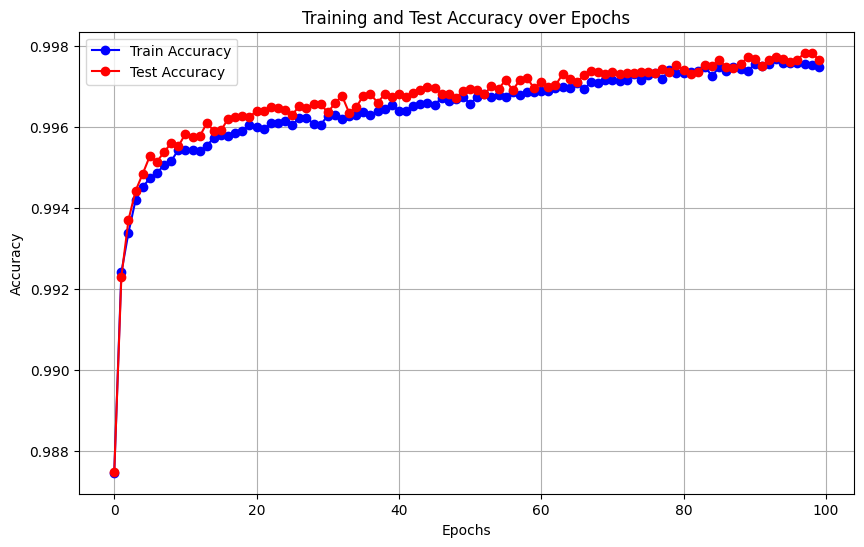

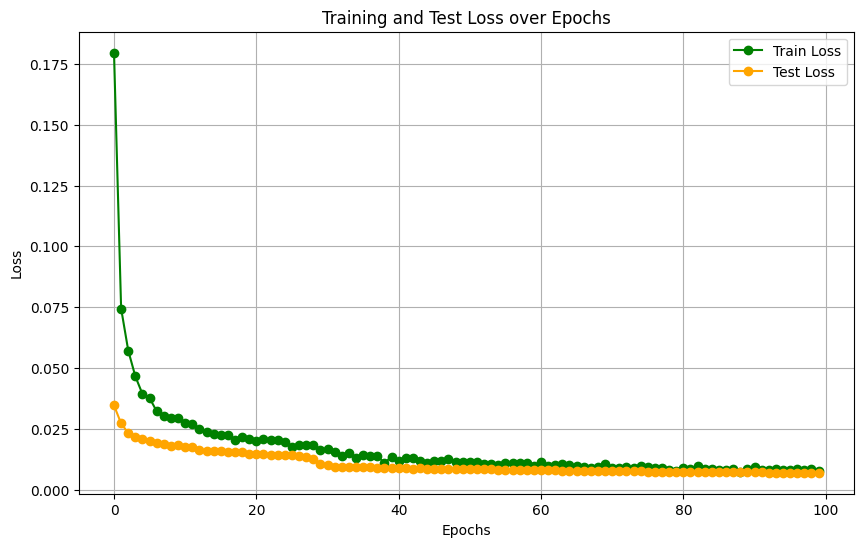

In [119]:
#prepare the data
path = 'generated_dataset.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(52)
# train the model
train_model(train_dl,test_dl, model)


In [123]:
import torch

from torch.jit import script
# Save the trained model
def save_model(model, path):
    scripted_model = script(model)  # Convertir le modèle en un modèle scripté
    scripted_model.save(path)  # Sauvegarder le modèle scripté

save_model(model, 'trained_model.pt')


In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9371 - loss: 0.1794 - val_accuracy: 0.9971 - val_loss: 0.0093
Epoch 2/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9965 - loss: 0.0149 - val_accuracy: 0.9978 - val_loss: 0.0066
Epoch 3/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 4/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9978 - loss: 0.0077 - val_accuracy: 0.9982 - val_loss: 0.0057
Epoch 5/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9986 - val_loss: 0.0052
Epoch 6/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 0.9986 - val_loss: 0.0048
Epoch 7/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9986 - val_loss: 0.0044
Epoch 8/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9983 - loss: 0.0055 - val_acc

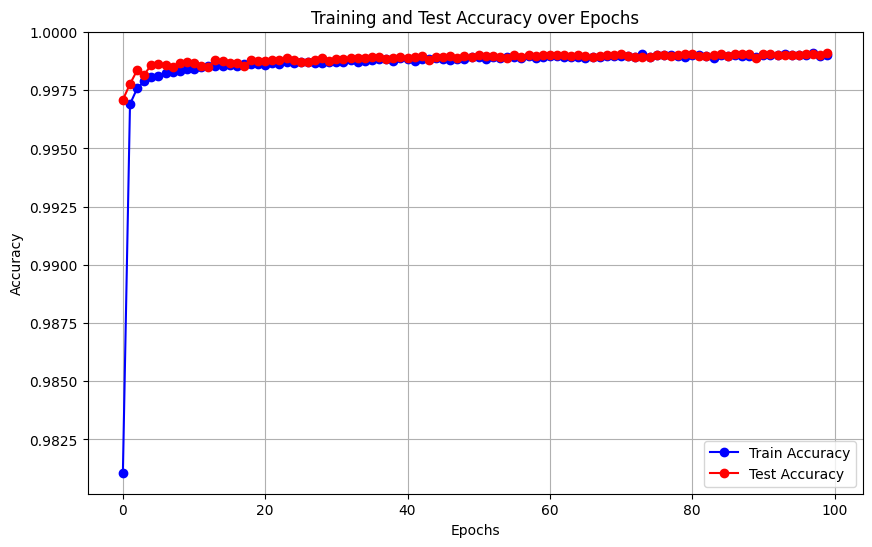

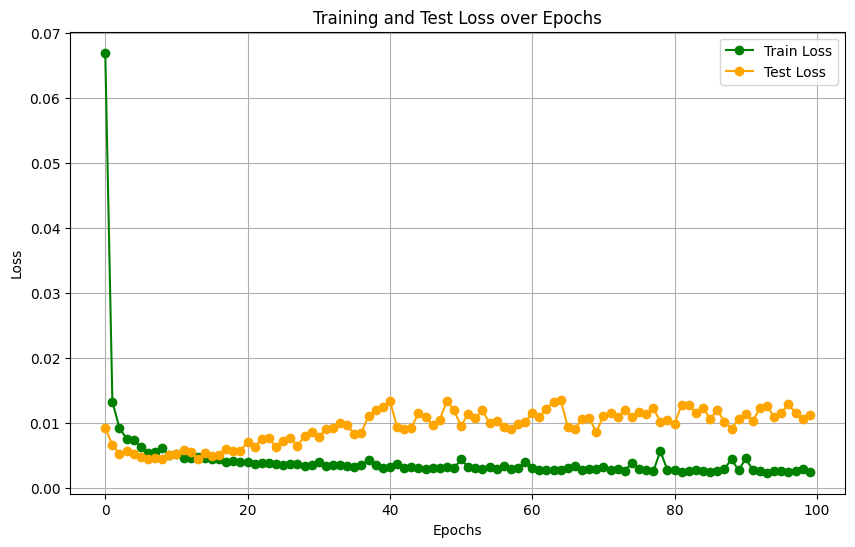

In [58]:
'''import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Charger et préparer le dataset
def prepare_data(path):
    df = pd.read_csv(path)
    
    # Encoder la colonne 'Protocol' si elle existe
    if 'Protocol' in df.columns:
        le_protocole = LabelEncoder()
        df['Protocol'] = le_protocole.fit_transform(df['Protocol'])
    
    # Diviser les features et la cible
    X = df.drop(columns=df.columns[-1]).values
    y = df.iloc[:, -1].values
    
    # Normalisation des features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Reshaper les données pour LSTM (ajouter une dimension pour la séquence)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time_steps, features)
    
    # Encodage des labels
    y = LabelEncoder().fit_transform(y)
    y = y.reshape((len(y), 1))
    
    return X, y

# Préparer les données
path = 'generated_dataset.csv'
X, y = prepare_data(path)

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Définir le modèle LSTM
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        layers.LSTM(128, activation='relu', input_shape=input_shape),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Sortie binaire
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Construire le modèle
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_test, y_test))

# Évaluer le modèle
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}% Test Loss: {test_loss:.4f}")

# Tracer l'historique de l'entraînement (précision et perte)

# Précision
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='red', linestyle='-', marker='o')
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Perte
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='green', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', color='orange', linestyle='-', marker='o')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
'''


In [110]:
path = 'generated_dataset.csv'
dataset = CSVDataset(path)

# Sauvegarder la ligne 5 des caractéristiques sous le format JSON
dataset.save_row_as_json(1, 'ligne_1_features.json')

In [128]:
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    # retrieve numpy array
    with torch.no_grad():
            prediction = model(row).numpy()
    return prediction

In [136]:
path = 'generated_dataset.csv'
dataset = CSVDataset(path)
row=dataset.get_row_for_prediction(9)
print(row)
yhat = predict(row, model)
print(yhat)

[-2.47793579e+00 -4.08372104e-01 -4.05181438e-01 -2.18049902e-02
 -7.71479011e-02 -2.59983409e-02 -2.72847146e-01  2.19089198e+00
 -2.34421581e-01 -1.45173979e+00  2.56749177e+00 -4.13281530e-01
 -1.66657060e-01 -2.80590039e-02 -3.87842774e-01 -4.03742224e-01
 -2.19479222e-02 -3.58663231e-01 -3.43598872e-01 -3.65028679e-01
 -1.91709250e-02 -2.74080724e-01 -3.15263897e-01 -7.07819834e-02
 -5.00218153e-01 -6.18732572e-01  0.00000000e+00 -4.89264220e-01
 -3.07532519e-01 -7.14906216e-01 -3.65029335e-01 -2.67093271e-01
 -1.39871836e+00 -2.09839606e+00 -6.16388798e-01 -6.20967746e-01
 -5.65414667e-01  3.02705646e-01 -3.59166376e-02 -5.03833145e-02
 -5.60023040e-02 -7.10306391e-02 -1.48108648e-03 -1.36392927e+00
 -3.57634634e-01 -1.85569286e+00 -2.60414600e-01 -9.39585194e-02
 -1.11897506e-01 -4.88441717e-03 -5.73631190e-03 -2.17401892e-01]
[[1.]]


In [101]:
path = 'generated_dataset.csv'
dataset = CSVDataset(path)

dataset.print_data()


Scaled and Normalized Features (X):
[[ 0.39524525 -0.39419052 -0.40285873 ... -0.00488442 -0.00573631
  -0.2160186 ]
 [ 0.39524525 -0.39419052 -0.40323734 ... -0.00488442 -0.00573631
  -0.21611992]
 [ 0.39524525 -0.39419052 -0.40340945 ... -0.00488442 -0.00573631
  -0.21613733]
 ...
 [ 0.39524525 -0.39419052 -0.4032091  ... -0.00488442 -0.00573631
  -0.21610901]
 [ 0.39524525  1.3438429  -0.25901735 ... -0.00488442 -0.00573631
  -0.18289542]
 [-2.4779358  -0.4083721  -0.40596685 ... -0.00488442 -0.00573631
  -0.21740189]]
Labels (y):
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]
